In [1]:
using Pkg
Pkg.activate("../")

using Base.Filesystem

# This is to read wav files.
# See: https://github.com/dancasimiro/WAV.jl
using WAV
using Plots

using Revise
using SpeechFeatures

 Activating environment at `~/GithubRepositories/SpeechFeatures/Project.toml`
┌ Info: Precompiling SpeechFeatures [6f3487c4-5ca2-4050-bfeb-2cf56df92307]
└ @ Base loading.jl:1278
ERROR: LoadError: LoadError: invalid subtyping in definition of HannWindow
Stacktrace:
 [1] top-level scope at /home/lucas/GithubRepositories/SpeechFeatures/src/windows.jl:9
 [2] include(::Function, ::Module, ::String) at ./Base.jl:380
 [3] include at ./Base.jl:368 [inlined]
 [4] include(::String) at /home/lucas/GithubRepositories/SpeechFeatures/src/SpeechFeatures.jl:1
 [5] top-level scope at /home/lucas/GithubRepositories/SpeechFeatures/src/SpeechFeatures.jl:6
 [6] include(::Function, ::Module, ::String) at ./Base.jl:380
 [7] include(::Module, ::String) at ./Base.jl:368
 [8] top-level scope at none:2
 [9] eval at ./boot.jl:331 [inlined]
 [10] eval(::Expr) at ./client.jl:467
 [11] top-level scope at ./none:3
in expression starting at /home/lucas/GithubRepositories/SpeechFeatures/src/windows.jl:9
in expression s

LoadError: Failed to precompile SpeechFeatures [6f3487c4-5ca2-4050-bfeb-2cf56df92307] to /home/lucas/.julia/compiled/v1.5/SpeechFeatures/EpiCb_E0Q89.ji.

Download an example audio file from the TIMIT 
corpus.

In [2]:
if ! isfile("LDC93S1.wav")
    run(`wget https://catalog.ldc.upenn.edu/desc/addenda/LDC93S1.wav`)
end

Load the audio file

sampling freq: 16000.0 Hz
duration: 2.92 s


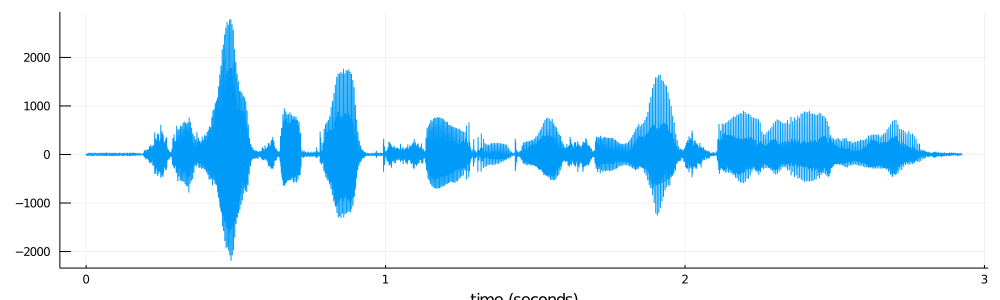

In [3]:
channels, srate = wavread("LDC93S1.wav", format="double")
channels *= typemax(Int16)

# TIMIT data has only one channel (i.e. "mono") 
x = channels[:, 1]

println("sampling freq: $srate Hz\nduration: $(round(length(x) / srate, digits=2)) s")

t = range(0, length(x) / srate, length=length(x))
plot(t, x, size=(1000, 300), xlabel="time (seconds)", legend = false)

In [5]:
stft = STFT(srate = 16000)

STFT{SpeechFeatures.HammingWindow}(16000, 0.025, 0.01, true, 0.0, 0.97, SpeechFeatures.HammingWindow(), 1.0)

In [6]:
x |> stft

LoadError: type STFT has no field T

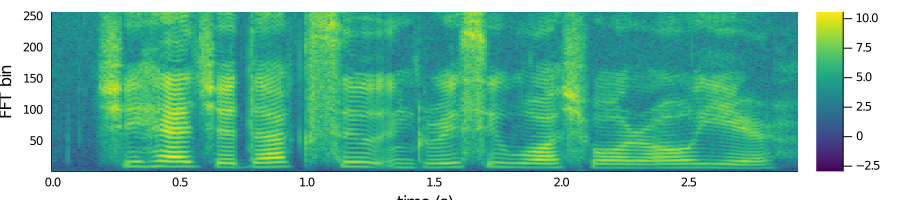

In [7]:
lms = LogMagnitudeSpectrum(
    fftlen = fftlen_auto,
    srate = 16000,
    frameduration = 0.025,
    framestep = 0.01,
    removedc = true,
    preemphasis = 0.97,
    dithering = 0.,
    windowfn = hann,
    windowpower = 1.0
)
fea = x |> lms

heatmap(
    Vector(range(0, length(x) / srate, length=size(fea, 2))),
    1:size(fea, 1),
    fea,
    size = (900, 200),
    xlabel = "time (s)",
    ylabel = "FFT bin",
    c = :viridis
)

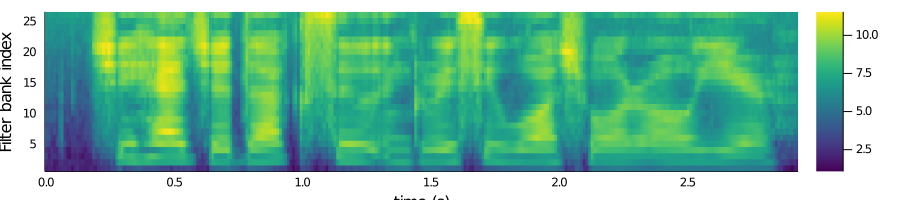

In [8]:
logfbank = LogMelSpectrum(
    fftlen = fftlen_auto,
    srate = 16000,
    frameduration = 0.025,
    framestep = 0.01,
    removedc = true,
    preemphasis = 0.97,
    dithering = 0.,
    windowfn = hann,
    windowpower = 1.0,
    nfilters = 26,
    lofreq = 80,
    hifreq = 8000
)
fea = x |> logfbank

heatmap(
    Vector(range(0, length(x) / srate, length=size(fea, 2))),
    1:size(fea, 1),
    fea,
    size = (900, 200),
    xlabel = "time (s)",
    ylabel = "Filter bank index",
    c = :viridis
)

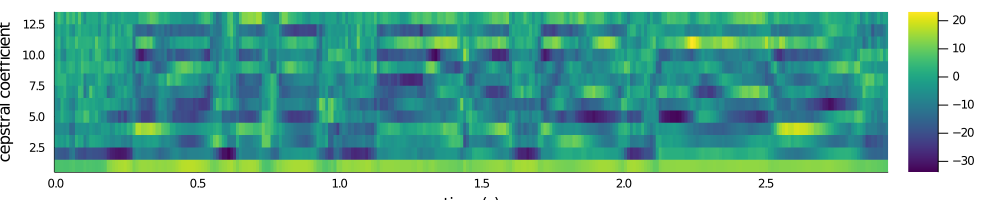

In [9]:
mfcc = MFCC(
    T = Float32, # Default is Float64
    fftlen = fftlen_auto,
    srate = 16000,
    frameduration = 0.025,
    framestep = 0.01,
    removedc = true,
    preemphasis = 0.97,
    dithering = 0.,
    windowfn = hann,
    windowpower = 0.85,
    nfilters = 26,
    lofreq = 80,
    hifreq = 8000,
    nceps = 12,
    liftering = 22,
    htkscaling = true,
    energy = rawenergy,
    energyfloor = 0.,
)
fea = x |> mfcc

heatmap(
    range(0, length(x) / srate, length=size(fea, 2)),
    1:size(fea, 1),
    fea,
    size = (1000, 200),
    xlabel = "time (s)",
    ylabel = "cepstral coefficient",
    c=:viridis
)

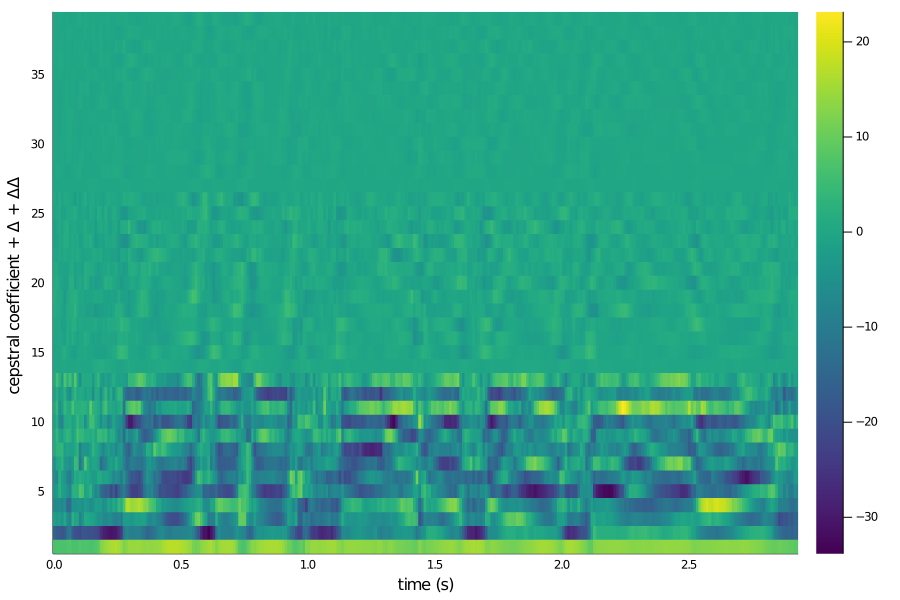

In [10]:
Δ_ΔΔ = DeltaCoeffs(
    order = 2, 
    win = 2
)
fea_Δ_ΔΔ = fea |> Δ_ΔΔ

heatmap(
    Vector(range(0, length(x) / srate, length=size(fea_Δ_ΔΔ, 2))),
    1:size(fea_Δ_ΔΔ, 1),
    fea_Δ_ΔΔ,
    size = (900, 600),
    xlabel = "time (s)",
    ylabel = "cepstral coefficient + Δ + ΔΔ ",
    c=:viridis
)